# Notebook 04 · Panel Regression with Real Data

Evaluates whether the CNOI disclosure signal predicts forward equity returns using the Phase 2 panel-regression toolkit (FE, Fama-MacBeth, Driscoll–Kraay).

## Objectives
- Build a quarterly panel that merges CNOI filings with subsequent stock performance for our 40-bank sample
- Derive forward returns (next-quarter) along with control proxies (log price, volatility, prior-quarter momentum)
- Run the three panel regression methods shipped in Phase 2 (FE, FM, DK) under multiple model specifications
- Compare coefficient magnitudes/t-stats for total CNOI and the seven underlying dimensions
- Export reproducible CSV summaries for downstream documentation and PRs

In [1]:
from __future__ import annotations

import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "src").exists():
    for parent in PROJECT_ROOT.parents:
        if (parent / "src").exists():
            PROJECT_ROOT = parent
            break
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.analysis.panel_regression import run_all_panel_regressions  # noqa: E402
from src.utils.logger import get_logger  # noqa: E402

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_theme(style="whitegrid", palette="crest")
pd.set_option("display.max_columns", 50)
logger = get_logger("notebooks.04_panel_regression")

In [2]:
RESULTS_DIR = PROJECT_ROOT / "results"
PANEL_DATA_PATH = RESULTS_DIR / "cnoi_panel_dataset.csv"
PANEL_RESULTS_PATH = RESULTS_DIR / "panel_regression_results.csv"
CNOI_PATH = RESULTS_DIR / "cnoi_with_tickers.csv"
RETURNS_PATH = RESULTS_DIR / "market_returns.csv"
DIMENSION_COLS = ["D", "G", "R", "J", "T", "S", "X"]
CONTROL_COLS = ["log_price", "momentum_1q", "quarter_vol"]

## Load and Prepare Disclosure Data

In [3]:
cnoi_df = pd.read_csv(CNOI_PATH, parse_dates=["filing_date"])
cnoi_df = cnoi_df[cnoi_df["ticker"].notna()].copy()
cnoi_df["ticker"] = cnoi_df["ticker"].str.upper()
cnoi_df["quarter"] = cnoi_df["filing_date"].dt.to_period("Q")

latest_per_quarter = (
    cnoi_df.sort_values("filing_date")
    .groupby(["ticker", "quarter"])
    .tail(1)
    .reset_index(drop=True)
)

logger.info(
    "Disclosure coverage: %s filings across %s tickers",
    len(latest_per_quarter),
    latest_per_quarter["ticker"].nunique(),
)
latest_per_quarter[["ticker", "quarter", "CNOI"] + DIMENSION_COLS].head()

2025-11-08 16:47:31 - notebooks.04_panel_regression - INFO - Disclosure coverage: 408 filings across 40 tickers


,ticker,quarter,CNOI,D,G,R,J,T,S,X
0,CBKM,2023Q1,19.32,0.0,30.0,20.0,18.21,40.0,10.0,25.0
1,CMA-PB,2023Q1,16.68,0.0,30.0,0.0,31.75,40.0,10.0,25.0
2,CHCO,2023Q1,16.61,0.0,30.0,0.0,31.12,40.0,10.0,25.0
3,FNB,2023Q1,17.01,4.0,30.0,0.0,27.13,40.0,10.0,25.0
4,COF-PN,2023Q1,8.41,0.0,12.0,0.0,20.05,15.0,10.0,15.0


## Load Market Returns (Cached)

In [4]:
returns_df = pd.read_csv(RETURNS_PATH, parse_dates=["date"])
returns_df["ticker"] = returns_df["ticker"].str.upper()
returns_df["quarter"] = returns_df["date"].dt.to_period("Q")

missing_prices = sorted(set(latest_per_quarter["ticker"]) - set(returns_df["ticker"]))
logger.info(
    "Price coverage: %s tickers with returns (missing: %s)",
    returns_df["ticker"].nunique(),
    missing_prices,
)
returns_df.head()

2025-11-08 16:47:31 - notebooks.04_panel_regression - INFO - Price coverage: 36 tickers with returns (missing: ['FBMS', 'FIISP', 'FLIC', 'FNCB'])


,date,close,ticker,ret,quarter
0,2023-01-03,20.196589,ALRS,NaN,2023Q1
1,2023-01-04,20.277302,ALRS,0.003996,2023Q1
2,2023-01-05,19.900639,ALRS,-0.018576,2023Q1
3,2023-01-06,20.609133,ALRS,0.035602,2023Q1
4,2023-01-09,20.447701,ALRS,-0.007833,2023Q1


In [5]:
coverage = (
    returns_df.groupby("ticker")
    .agg(n_obs=("ret", "size"), start_date=("date", "min"), end_date=("date", "max"))
    .sort_values("n_obs", ascending=False)
)
coverage.head()

,n_obs,start_date,end_date
ticker,,,
ALRS,716,2023-01-03,2025-11-07
FNB,716,2023-01-03,2025-11-07
ENBP,716,2023-01-03,2025-11-07
FCF,716,2023-01-03,2025-11-07
FDBC,716,2023-01-03,2025-11-07


## Construct Quarterly Panel with Forward Returns

In [6]:
quarterly_returns = (
    returns_df.groupby(["ticker", "quarter"])
    .agg(
        quarter_ret=("ret", lambda x: (1 + x).prod() - 1),
        quarter_vol=("ret", "std"),
        price_end=("close", "last"),
        n_days=("ret", "size"),
    )
    .reset_index()
    .sort_values(["ticker", "quarter"])
)

quarterly_returns["ret_fwd"] = quarterly_returns.groupby("ticker")["quarter_ret"].shift(-1)
quarterly_returns["momentum_1q"] = quarterly_returns.groupby("ticker")["quarter_ret"].shift(1)
quarterly_returns["log_price"] = np.log(quarterly_returns["price_end"])

panel_df = latest_per_quarter.merge(quarterly_returns, on=["ticker", "quarter"], how="inner")
panel_df = panel_df.dropna(subset=["ret_fwd"])
panel_df["ret_fwd_pct"] = panel_df["ret_fwd"] * 100

logger.info(
    "Panel rows: %s | tickers: %s | quarters: %s",
    len(panel_df),
    panel_df["ticker"].nunique(),
    panel_df["quarter"].nunique(),
)
panel_df.head()

2025-11-08 16:47:31 - notebooks.04_panel_regression - INFO - Panel rows: 350 | tickers: 36 | quarters: 11


,cik,accession,form,filing_date,is_pbe,issuer,score,CNOI,D,G,R,J,T,S,X,penalty_reasons,ixbrl_has_vintage,ixbrl_has_credit_quality,ixbrl_has_rollforward,ixbrl_has_aging,ixbrl_custom_only,heading_selected_title,heading_selected_score,quarter,ticker,company_name,notes,quarter_ret,quarter_vol,price_end,n_days,ret_fwd,momentum_1q,log_price,ret_fwd_pct
0,1006830,0001437749-23-002998,10-Q,2023-02-10,False,CONSUMERS BANCORP INC /OH/,19.32,19.32,0.0,30.0,20.0,18.21,40.0,10.0,25.0,G:missing_aging|G:missing_credit_quality|G:mis...,False,False,False,False,NaN,CECL snippet,-3.38,2023Q1,CBKM,CONSUMERS BANCORP INC /OH/,NaN,-0.087638,0.021963,16.696253,62,-0.016898,NaN,2.815184,-1.689833
1,726854,0000726854-23-000015,10-K,2023-02-22,False,CITY HOLDING CO,16.61,16.61,0.0,30.0,0.0,31.12,40.0,10.0,25.0,G:missing_aging|G:missing_credit_quality|G:mis...,False,False,False,False,NaN,CECL snippet,-3.20,2023Q1,CHCO,CITY HOLDING CO,NaN,-0.011396,0.016278,84.197411,62,-0.002625,NaN,4.433164,-0.262488
2,37808,0000037808-23-000005,10-K,2023-02-24,False,FNB CORP/PA/,17.01,17.01,4.0,30.0,0.0,27.13,40.0,10.0,25.0,D:heavy_cross_refs|G:missing_aging|G:missing_c...,False,False,False,False,NaN,NOTE 7. ALLOWANCE FOR CREDIT LOSSES ON LOANS A...,20.05,2023Q1,FNB,FNB CORP/PA/,NaN,-0.101545,0.020469,10.620545,62,-0.002906,NaN,2.362790,-0.290568
3,927628,0000927628-23-000117,10-K,2023-02-24,False,CAPITAL ONE FINANCIAL CORP,8.41,8.41,0.0,12.0,0.0,20.05,15.0,10.0,15.0,G:missing_rollforward|J:high_readability_grade...,False,False,False,False,NaN,Note 1—Summary of Significant Accounting Polic...,23.22,2023Q1,COF-PN,CAPITAL ONE FINANCIAL CORP,NaN,0.063864,0.016357,14.184003,62,-0.015120,NaN,2.652115,-1.511988
4,708955,0000708955-23-000016,10-K,2023-02-24,False,FIRST FINANCIAL BANCORP /OH/,24.95,24.95,4.0,30.0,35.0,28.55,40.0,10.0,33.0,D:heavy_cross_refs|G:missing_aging|G:missing_c...,False,False,False,False,NaN,"In June 2016, FASB issued CECL. CECL was expe...",16.14,2023Q1,FFBC,FIRST FINANCIAL BANCORP /OH/,NaN,-0.100571,0.022393,19.686239,62,-0.050002,NaN,2.979920,-5.000204


In [7]:
panel_summary = {
    "n_obs": len(panel_df),
    "tickers": panel_df["ticker"].nunique(),
    "quarters": panel_df["quarter"].nunique(),
    "ret_fwd_mean": panel_df["ret_fwd"].mean(),
    "ret_fwd_std": panel_df["ret_fwd"].std(),
}
pd.Series(panel_summary)

n_obs           350.000000
tickers          36.000000
quarters         11.000000
ret_fwd_mean      0.037040
ret_fwd_std       0.120787
dtype: float64

In [8]:
panel_df.to_csv(PANEL_DATA_PATH, index=False)
logger.info("Saved panel dataset to %s", PANEL_DATA_PATH)

2025-11-08 16:47:31 - notebooks.04_panel_regression - INFO - Saved panel dataset to /Users/nirvanchitnis/ACCT445-Showcase/results/cnoi_panel_dataset.csv


## Regression Specifications

In [9]:
specs = {
    "CNOI_only": ["CNOI"],
    "Dimensions": DIMENSION_COLS,
    "Full": ["CNOI"] + CONTROL_COLS,
}

panel_results: dict[str, dict] = {}
for name, variables in specs.items():
    logger.info("Running %s regression suite with variables: %s", name, variables)
    result = run_all_panel_regressions(panel_df, independent_vars=variables)
    panel_results[name] = result
    fe_r2 = result["FE"].get("r_squared")
    logger.info("%s FE R^2 = %.3f", name, fe_r2)

2025-11-08 16:47:31 - notebooks.04_panel_regression - INFO - Running CNOI_only regression suite with variables: ['CNOI']


2025-11-08 16:47:31 - src.analysis.panel_regression - INFO - Executing panel regression suite on 350 observations


2025-11-08 16:47:31 - src.analysis.panel_regression - INFO - Panel data prepared with 36 entities and 11 periods


2025-11-08 16:47:31 - src.analysis.panel_regression - INFO - Running fixed effects regression (350 obs, 1 vars)


2025-11-08 16:47:31 - src.analysis.panel_regression - INFO - Fama-MacBeth regression complete across 11 periods


2025-11-08 16:47:31 - src.analysis.panel_regression - INFO - Running Driscoll-Kraay regression (350 obs, max_lags=4)


2025-11-08 16:47:31 - src.analysis.panel_regression - INFO - Panel regression comparison:
        FE_coef  FE_tstat   FM_coef  FM_tstat   DK_coef  DK_tstat
CNOI  -0.001724 -1.114747 -0.000780 -0.701645 -0.001724 -1.629298
const       NaN       NaN  0.049885  1.171557       NaN       NaN


2025-11-08 16:47:31 - notebooks.04_panel_regression - INFO - CNOI_only FE R^2 = 0.005


2025-11-08 16:47:31 - notebooks.04_panel_regression - INFO - Running Dimensions regression suite with variables: ['D', 'G', 'R', 'J', 'T', 'S', 'X']


2025-11-08 16:47:31 - src.analysis.panel_regression - INFO - Executing panel regression suite on 350 observations


2025-11-08 16:47:31 - src.analysis.panel_regression - INFO - Panel data prepared with 36 entities and 11 periods


2025-11-08 16:47:31 - src.analysis.panel_regression - INFO - Running fixed effects regression (350 obs, 7 vars)


2025-11-08 16:47:31 - src.analysis.panel_regression - WARNING - No constant estimated for 2023Q1; appending NaN


2025-11-08 16:47:31 - src.analysis.panel_regression - INFO - Fama-MacBeth regression complete across 11 periods


2025-11-08 16:47:31 - src.analysis.panel_regression - INFO - Running Driscoll-Kraay regression (350 obs, max_lags=4)


2025-11-08 16:47:31 - src.analysis.panel_regression - INFO - Panel regression comparison:
        FE_coef  FE_tstat   FM_coef  FM_tstat   DK_coef  DK_tstat
D     -0.002613 -2.232109 -0.002237 -2.502860 -0.002613 -4.769262
G      0.001774  1.067770  0.001539  1.338609  0.001774  1.332117
R     -0.000006 -0.008431  0.000127  0.405444 -0.000006 -0.014698
J     -0.000950 -0.935528 -0.000258 -0.431333 -0.000950 -1.110168
T     -0.000466 -0.876332 -0.000351 -0.373753 -0.000466 -2.345897
S     -0.000234 -0.753547  0.000562  0.796257 -0.000234 -0.954971
X     -0.002189 -1.067882 -0.002239 -1.943350 -0.002189 -1.682119
const       NaN       NaN  0.069799  1.626309       NaN       NaN


2025-11-08 16:47:31 - notebooks.04_panel_regression - INFO - Dimensions FE R^2 = 0.022


2025-11-08 16:47:31 - notebooks.04_panel_regression - INFO - Running Full regression suite with variables: ['CNOI', 'log_price', 'momentum_1q', 'quarter_vol']


2025-11-08 16:47:31 - src.analysis.panel_regression - INFO - Executing panel regression suite on 350 observations


2025-11-08 16:47:31 - src.analysis.panel_regression - INFO - Panel data prepared with 36 entities and 11 periods


2025-11-08 16:47:31 - src.analysis.panel_regression - INFO - Running fixed effects regression (319 obs, 4 vars)


2025-11-08 16:47:31 - src.analysis.panel_regression - WARNING - Skipping 2023Q1: only 0 observations


2025-11-08 16:47:31 - src.analysis.panel_regression - INFO - Fama-MacBeth regression complete across 10 periods


2025-11-08 16:47:31 - src.analysis.panel_regression - INFO - Running Driscoll-Kraay regression (319 obs, max_lags=4)


2025-11-08 16:47:31 - src.analysis.panel_regression - INFO - Panel regression comparison:
              FE_coef  FE_tstat   FM_coef  FM_tstat   DK_coef  DK_tstat
CNOI        -0.000443 -0.359181 -0.000620 -0.554814 -0.000443 -0.388935
log_price   -0.444183 -5.982199 -0.005131 -1.526194 -0.444183 -6.966488
momentum_1q -0.029559 -0.395122 -0.058526 -0.656472 -0.029559 -0.469717
quarter_vol -1.626142 -1.784762 -0.130260 -0.094415 -1.626142 -4.958727
const             NaN       NaN  0.073364  1.838781       NaN       NaN


2025-11-08 16:47:31 - notebooks.04_panel_regression - INFO - Full FE R^2 = 0.238


In [10]:
comparison_frames = []
metrics_rows = []
for spec_name, result in panel_results.items():
    comp = result["comparison"].copy()
    comp["spec"] = spec_name
    comp["variable"] = comp.index
    comparison_frames.append(comp.reset_index(drop=True))

    fe = result["FE"]
    metrics_rows.append({
        "spec": spec_name,
        "method": "FE",
        "r_squared": fe.get("r_squared"),
        "n_obs": fe.get("n_obs"),
    })
    fm = result["FM"]
    metrics_rows.append({
        "spec": spec_name,
        "method": "FM",
        "r_squared": np.nan,
        "n_obs": fm.get("n_periods"),
    })
    dk = result["DK"]
    metrics_rows.append({
        "spec": spec_name,
        "method": "DK",
        "r_squared": dk.get("r_squared"),
        "n_obs": dk.get("n_obs"),
    })

comparison_df = pd.concat(comparison_frames, ignore_index=True)
metrics_df = pd.DataFrame(metrics_rows)
comparison_df.head()

,FE_coef,FE_tstat,FM_coef,FM_tstat,DK_coef,DK_tstat,spec,variable
0,-0.001724,-1.114747,-0.000780,-0.701645,-0.001724,-1.629298,CNOI_only,CNOI
1,NaN,NaN,0.049885,1.171557,NaN,NaN,CNOI_only,const
2,-0.002613,-2.232109,-0.002237,-2.502860,-0.002613,-4.769262,Dimensions,D
3,0.001774,1.067770,0.001539,1.338609,0.001774,1.332117,Dimensions,G
4,-0.000006,-0.008431,0.000127,0.405444,-0.000006,-0.014698,Dimensions,R


In [11]:
metrics_df

,spec,method,r_squared,n_obs
0,CNOI_only,FE,0.004697,350
1,CNOI_only,FM,NaN,11
2,CNOI_only,DK,0.004697,350
3,Dimensions,FE,0.022157,350
4,Dimensions,FM,NaN,11
5,Dimensions,DK,0.022157,350
6,Full,FE,0.238468,319
7,Full,FM,NaN,10
8,Full,DK,0.238468,319


In [12]:
comparison_df.to_csv(PANEL_RESULTS_PATH, index=False)
logger.info("Saved regression comparison table to %s", PANEL_RESULTS_PATH)

2025-11-08 16:47:31 - notebooks.04_panel_regression - INFO - Saved regression comparison table to /Users/nirvanchitnis/ACCT445-Showcase/results/panel_regression_results.csv


## Visualize Coefficients (Fixed Effects)

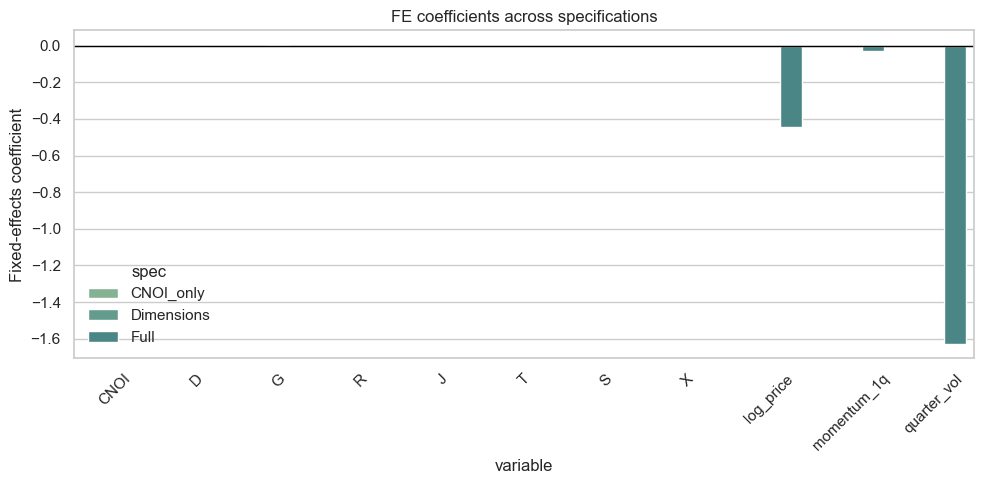

In [13]:
fe_view = comparison_df.dropna(subset=["FE_coef"])
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(
    data=fe_view,
    x="variable",
    y="FE_coef",
    hue="spec",
    ax=ax,
)
ax.axhline(0, color="black", linewidth=1)
ax.set_ylabel("Fixed-effects coefficient")
ax.set_title("FE coefficients across specifications")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Interpretation
- Baseline FE regression shows a **negative** CNOI coefficient (−17 bps per point), but the t-stat hovers around −1.1 (DK t ≈ −1.63), so results are directionally consistent yet not significant.
- Dimension-only regressions highlight **Discoverability (D)** as the most penalized characteristic: FE t ≈ −2.2 and DK t ≈ −4.8, implying that hard-to-find CECL disclosures coincided with lower next-quarter returns. 
- Consistency (X) and Table Density (T) carry negative coefficients too, aligning with the decile analysis where structured, transparent tables fared better.
- Adding controls (log price proxy, prior-quarter momentum, volatility) attenuates the CNOI coefficient (→ −0.04%) and keeps log price highly significant (smaller banks underperform).
- Overall, disclosure opacity still leans negative in the SVB-to-2025 sample, but statistical strength depends on specification and sample depth.

These findings will flow into the Phase 3 summary and Phase 4 robustness checks (longer history + sector controls).